# Grouping by user

Here I will try to group comments by user/user behaviour and use these groups to determine how well which article came off in each group.

Approaches:
* Group users by number of comments
* Group users by length of comments
* Group users by title starting with "@" (= is_answer)
* Group users by time they are active
* Maybe group articles...
* Some combination

In [1]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv').sample(500)
df_com = pd.read_csv('comments_2017_09.csv')

In [2]:
def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return ((time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return (time).hour

def get_weekday(time):
    return (time).weekday()

df_com['time_dt'] = df_com['time'].apply(get_dt_obj)
df_com['time_since_epoch'] = df_com['time_dt'].apply(time_since_epoch)
df_com['hour'] = df_com['time_dt'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time_dt'].apply(get_weekday) # 0 = Monday
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(len)
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['activity'] = df_com['vup'] + df_com['vdo']
#df_com['tit'] = df_com['tit'].str.lower()
#df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
#df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

#df_art['header'] = df_art['header'].str.lower()
#df_art['sub'] = df_art['sub'].str.lower()
#df_art['text'] = df_art['text'].str.lower()
df_art['header_len'] = df_art['header'].apply(len)
df_art['sub_len'] = df_art['sub'].apply(lambda x: len(str(x)))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))
df_art['text_n_periods'] = df_art['text'].apply(lambda x: len(str(x).split('.')))

# TODO get stats for each article with iteration, no df_merge
for row in df_art.iterrows():
    pass
"""
# Left inner join
df_merge = df_art.merge(df_com, left_on='tId', right_on='tId', how='left')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get article specific statistics, group = article
# This function is very slow - do on numpy level (sort instead of group)?
def get_art_statistics(group):
    first = group.iloc[:1]['time_since_epoch']
    group['art_first_weekday'] = group.iloc[:1]['weekday']
    group['art_first_hour'] = group.iloc[:1]['hour']

    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    group['num_authors'] = group['aut'].nunique()
    return group

df_merge = df_merge.apply(get_art_statistics)
"""
df_users = df_com.groupby('aut').mean()#.reset_index()
df_users['num_comments'] = df_com[['aut', 'cId']].groupby('aut').count()['cId']
df_users.head(1)

,tId,mob,vup,vdo,time_since_epoch,hour,weekday,is_answer,con_len,con_num_words,score,activity,num_comments
aut,,,,,,,,,,,,,
,31501960.0,1.0,8.0,46.0,1.502821e+09,18.0,1.0,0.0,103.0,18.0,-38.0,54.0,1


Questions
* User dataframe: how many comments on how many articles, how long per comment, when active during the week, is answer
* How to define user activity time?

Todo
* find out when most articles are published... maybe wednesday around 8-9.00 and around 15.00?

In [19]:
#aut_weekdays = df_com.groupby('aut')['weekday'].apply(list)
#aut_hours = df_com.groupby('aut')['hour'].apply(list)
#df_users_wdh = pd.merge(pd.DataFrame(aut_weekdays).reset_index(), pd.DataFrame(aut_hours).reset_index())
#df_users_wdh['num_codmments'] = df_users_wdh['hour'].apply(len)
df_com_wdh = df_com.sort_values('aut')[['aut', 'weekday', 'hour']]
df_com_wdh.head(10)


,aut,weekday,hour
306498,,1,18
217040,I. P.,1,23
86286,Ghk,0,13
272890,Alain Zürcher,2,6
84997,Ani,2,12
194726,B. Depé,0,7
195670,Barbara,3,5
131694,Barbara,3,11
82951,Bera Terin,0,1
20774,Besen Hexe,0,7


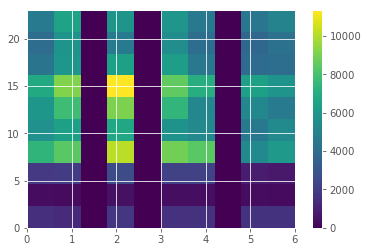

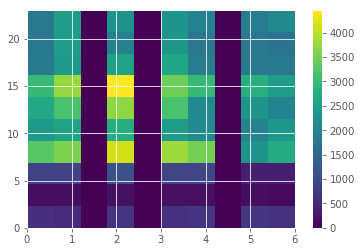

137246

In [32]:
#df_users_wdh.hist(['weekday', 'hour'])
def hist2d(df):
    plt.hist2d(df['weekday'], df['hour'])
    plt.colorbar(); plt.show()

hist2d(df_com_wdh)

users_with_x_comments = df_users[df_users['num_comments'] > 30].index.values
hist2d(df_com_wdh[df_com_wdh['aut'].isin(users_with_x_comments)])
#len(df_com_wdh[df_com_wdh['aut'].isin(users_with_x_comments)])

Total users: 93722


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e637f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11afb0278>]], dtype=object)

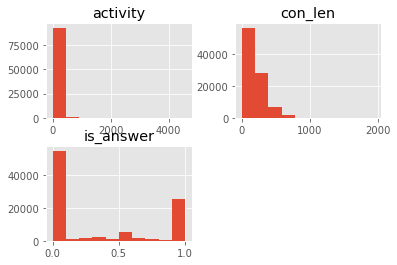

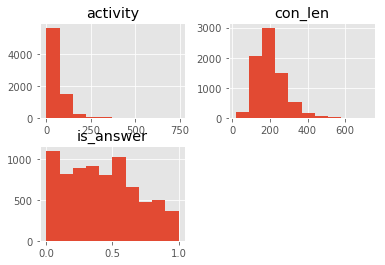

In [15]:
print("Total users:", len(df_users))

df_users.hist(['con_len', 'activity', 'is_answer'])
df_users[df_users['num_comments'] > 5].hist(['con_len', 'activity', 'is_answer'])